In [1]:
import pandas as pd
import glob
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import gzip

from tqdm import tqdm_notebook
from nltk.util import ngrams
from wordcloud import WordCloud
from IPython.display import display, HTML

First we need to combine all data files, since the data set is split among different files

In [4]:
df = pd.concat([pd.read_csv(f, delimiter='\t') for f in glob.glob('/Users/rwkoops/PycharmProjects/IR_project/IR_project_02/data/user-ct-test-collection-*.txt')])

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Next up, we randomly sample 1 million queries from the data set

In [6]:
queries = df.sample(1000000, random_state=23)

Then, we create all possible suffixes by splitting the queries in words and iteratively removing the leading word, during this process, we normalize URLs by using a regex that detects the dots in URLs and replaces them by spaces.

In [7]:
suffixes = []

for i, row in tqdm_notebook(queries.iterrows(), total=queries.shape[0]):
    query = row['Query']
    if isinstance(query, str):
        line = re.sub(r"\.(.)", r" \1", query)
        words = line.split()
        for j in range(0, len(words)):
            suffix = " ".join(words[j:])
            suffixes.append(suffix)

#np.save('pickles/historical_logs', suffixes)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Since this process takes quite a while, we store the results. We choose a compressed format since the array is very large and needs to be stored efficiently.

In [9]:
f = gzip.GzipFile("/Users/rwkoops/PycharmProjects/IR_project/IR_project_02/pickles/historical_logs.npy.gz", "w")
np.save(file=f, arr=suffixes)
f.close()

If we already have a save-file, we can skip the steps performed before and start from this point on by reading the file in.

In [ ]:
# f = gzip.GzipFile('pickles/historical_logs.npy.gz', "r")
# suffixes = np.load(f)


We create a dictionary of all the candidates by using a counter from the collections library. We sort the values to analyze the top-n occuring candidates.

In [10]:
historical_dict = collections.Counter(suffixes)
historical_sorted = sorted(historical_dict, key=historical_dict.get, reverse=True)

The method below creates a dataframe ranking the top n-word suffixes in the historical logs.

In [11]:
def create_ranking(sorted_history, top_n=10, max_word_length=3):

    top_candidates = pd.DataFrame(index=range(1, top_n+1))
    
    indices = [1] * max_word_length
    
    for suffix in sorted_history:
        length = len(suffix.split())
        for i in range(1, max_word_length + 1):
            if length == i and indices[i-1] <= top_n:
                top_candidates.at[indices[i-1], "Top "+str(i)+"-word suffixes"] = suffix
                indices[i-1] += 1
    return top_candidates

To demonstrate, below we create the top 20 n-word rankings for n = 1 to n = 5.

In [12]:
top_candidates = create_ranking(historical_sorted, top_n=20, max_word_length=5)
display(HTML(top_candidates.to_html()))

,Top 1-word suffixes,Top 2-word suffixes,Top 3-word suffixes,Top 4-word suffixes,Top 5-word suffixes
1,com,yahoo com,www yahoo com,deal or no deal,keywords or web addresses here
2,-,myspace com,www google com,www disney channel com,antique car shows in alabama
3,google,google com,www myspace com,bed bath and beyond,mother of the bride dresses
4,org,for sale,bank of america,in new york city,y s e evergreen solar
5,net,ebay com,my space com,www my space com,www bank of america com
6,ebay,new york,adserver ign com,or web addresses here,television images and theme songs
7,lyrics,real estate,mycl cravelyrics com,bank of america com,wants to be a millionaire
8,yahoo,hotmail com,disney channel com,for sale by owner,k nshop rgift thm s
9,pictures,my space,www ebay com,car shows in alabama,http www disney channel com
10,gov,of america,www hotmail com,days of our lives,mystery case files prime suspects


We can also visualize the frequencies of the top n-word suffixes using word clouds. Below we visualize the top 20 4-word suffixes.

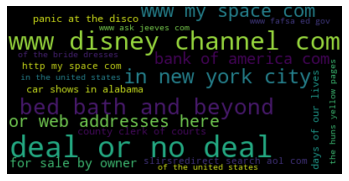

In [13]:
def gen_wordcloud(dictionary, amount_words, n=10):
    new_dict = {}
    for (key, value) in dictionary.items():
        if len(key.split()) == amount_words:
           new_dict[key] = value
    
    
    wordcloud = WordCloud(max_words=n).generate_from_frequencies(new_dict)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

gen_wordcloud(historical_dict, 4, 20)

The next features we need are the n-gram frequencies, as they are called in the paper. Below the method for the generation of these features is implemented.

In [14]:
def ngram_freq(candidate, historical_logs, n=6):
    words = candidate.split()
    ngram_features = []
    for i in range(1, n + 1):
        ngramfreq_i = 0
        ngrams_i = ngrams(words, i)
        for word in ngrams_i:
            freq_g = historical_logs[" ".join(word)]
            ngramfreq_i += freq_g
        ngram_features.append(ngramfreq_i)
    return ngram_features

An example of a candidate is "place to live in the greek islands for americans". Below we show the extraction of the ngram frequencies for up to 6-grams of this candidate. The number at index i is how often all of the (i+1)-grams occur in the historical logs

In [15]:
candidate = "place to live in the greek islands for americans"
ngramfeatures = ngram_freq(candidate, historical_dict, n=6)
ngramfeatures

[1141, 63, 12, 0, 0, 0]

Finally, the last features are:
* The frequency of the candidate in the historical logs
* The length of the prefix in chars and words
* The length of the suffix in chars and words
* The length of the candidate in chars and words
* A binary feature indicating whether the prefix ends with a space

In [16]:
def get_other_features(candidate, historical_logs):
    # The prefix of the candidate
    prefix = candidate[0]
    
    # Boolean indicating whether the prefix ends with a space
    bool_space = prefix.endswith(" ")
    
    # The suffix of the candidate
    suffix = candidate[1]
    
    # The complete query
    complete = ""
    if bool_space:
        complete = candidate[0] + candidate[1]
    else:
        complete = candidate[0] + " " + candidate[1]
    
    # The frequency of the candidate in the historical logs
    frequency = historical_logs[complete]
    
    # Prefix, suffix and total length in characters
    prefixlen_char = len(prefix)
    suffixlen_char = len(suffix)
    totallen_char = len(complete)
    
    # Prefix, suffix and total length in words
    prefixlen_word = len(prefix.split())
    suffixlen_word = len(suffix.split())
    totallen_word = len(complete.split())
    
    return [frequency, 
            prefixlen_char, suffixlen_char, totallen_char,
            prefixlen_word, suffixlen_word, totallen_word,
            bool_space * 1]

Below is an example of the extraction of the 'other features' from two example candidates

In [17]:
candidate1 = ["How to", "cook an egg"]
candidate2 = ["The best places ", "to visit"]

f1 = get_other_features(candidate1, historical_dict)
f2 = get_other_features(candidate2, historical_dict)
print(f1)
print(f2)

[0, 6, 11, 18, 2, 3, 5, 0]
[0, 16, 8, 24, 3, 2, 5, 1]
